## Optional first step installing packages

In [1]:
# import sys
# !{sys.executable} -m pip install geofeather
# !{sys.executable} -m pip install nhdnet  #see Setup info document 

### Loading modules

In [2]:
from pathlib import Path
import os
from time import time
import geopandas as gp
import geofeather

from geofeather import to_geofeather
from nhdnet.nhd.extract import extract_flowlines
# from nhdnet.nhd.extract import extract_waterbodies
from nhdnet.io import serialize_df, serialize_sindex, to_shp  

## Initial setup and constants

In [3]:
#Select HUC of interest
HUC2 = 10
i = 19
HUC4 = "{0}{1:02d}".format(HUC2, i)  # this formats the HUC4 name how we want it. ':02d' is string formatting
print(HUC4)
print(type(HUC4))
huc_id = int(HUC4) * 1000000   # the full HUC4 ID
print(huc_id)

data_dir = Path("data/nhd/source/huc4")  # point to where GDBs are

#Setting projections
CRS = {           # Using USGS CONUS Albers (EPSG:102003): https://epsg.io/102003  WHY?
    "proj": "aea",
    "lat_1": 29.5,
    "lat_2": 45.5,
    "lat_0": 37.5,
    "lon_0": -96,
    "x_0": 0,
    "y_0": 0,
    "datum": "NAD83",
    "units": "m",
    "no_defs": True,
}

1019
<class 'str'>
1019000000


## Read in the geodatabase

In [4]:
# sys.path.append('/Users/rachelspinti/Documents/River_bifurcation/data/nhd/source/huc4/1019') #call where these scripts are located

gdb = data_dir/HUC4/ "NHDPLUS_H_{HUC4}_HU4_GDB.gdb".format(HUC4=HUC4)
print(gdb)
read_start = time()
flowlines, joins = extract_flowlines(gdb, target_crs=CRS)
print("Read {:,} flowlines in  {:.0f} seconds".format(len(flowlines), time() - read_start))

data/nhd/source/huc4/1019/NHDPLUS_H_1019_HU4_GDB.gdb
Reading flowlines
Columns= <bound method NDFrame.head of            NHDPlusID  FlowDir  FType   GNIS_ID             GNIS_Name  \
0       2.300190e+13        1    460      None                  None   
1       2.300190e+13        1    460      None                  None   
2       2.300190e+13        1    460      None                  None   
3       2.300190e+13        1    460      None                  None   
4       2.300190e+13        1    460      None                  None   
...              ...      ...    ...       ...                   ...   
232506  2.300190e+13        1    460      None                  None   
232507  2.300190e+13        1    460  00184959  West Toll Gate Creek   
232508  2.300190e+13        1    334      None                  None   
232509  2.300190e+13        1    558      None                  None   
232510  2.300190e+13        1    336  00203030      Burlington Ditch   

                         

## Getting information about what came out of this

First for the flowlines -- this is a geodataframe with the flowline geometry. Comes from *flowlines.py*

['NHDPlusID', 'FType', 'GNIS_ID', 'GNIS_Name', 'geometry', 'ReachCode', 'lineID', 'streamorder', 'TotDASqKm', 'sizeclass', 'length', 'sinuosity']


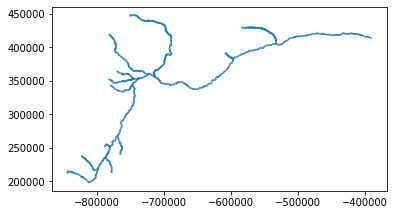

In [5]:
# type(flowlines)
# flowlines.head(3)
# print(flowlines)
# flowlines.plot()
# print(flowlines.shape)
print(list(flowlines.columns))
# print(flowlines[flowlines.streamorder>6])
flowlines[flowlines.streamorder>6].plot()

In [23]:
flowlines.head(10)

,geometry,lineID,NHDPlusID,ReachCode,FType,length,sinuosity,sizeclass,streamorder
NHDPlusID,,,,,,,,,
23001900008851,"LINESTRING (-800081.762 215515.782, -800082.87...",1019000001,23001900008851,10190001010972,460,486.965546,1.082492,1a,1
23001900008863,"LINESTRING (-799823.525 221309.940, -799829.56...",1019000002,23001900008863,10190002021576,460,81.604347,1.008270,1a,1
23001900008864,"LINESTRING (-800259.206 220461.613, -800252.86...",1019000003,23001900008864,10190002022431,460,480.924530,1.016657,1a,1
23001900008865,"LINESTRING (-799873.180 220328.121, -799869.36...",1019000004,23001900008865,10190002022326,460,239.971359,1.041028,1a,1
23001900008866,"LINESTRING (-800502.522 224009.874, -800489.40...",1019000005,23001900008866,10190002002172,460,149.139175,1.022822,1a,2
23001900008867,"LINESTRING (-800696.726 223529.142, -800688.63...",1019000006,23001900008867,10190002002197,460,374.499329,1.054500,1a,2
23001900008514,"LINESTRING (-784197.161 402521.348, -784185.33...",1019000007,23001900008514,10190007011206,460,100.414604,1.003612,1a,2
23001900009741,"LINESTRING (-794689.467 258885.462, -794681.70...",1019000008,23001900009741,10190002040388,460,552.855591,1.048819,1a,1
23001900009742,"LINESTRING (-794453.545 258347.339, -794445.24...",1019000009,23001900009742,10190002040416,460,237.721313,1.029272,1a,1


Then for the joins - this is a dataframe with the linkage information. Comes from *flowlines.py*

In [20]:
type(joins)
joins.head(3)
# set(joins.type)
x = joins[joins.type == 'origin']
print(x)
# joins.plot()
# joins[joins.downstream_id>0].plot()  # plotting test
# print(joins.describe)


        upstream      downstream  upstream_id  downstream_id    type
0              0  23001900145002            0     1019106322  origin
1              0  23001900145006            0     1019106326  origin
2              0  23001900145007            0     1019106327  origin
3              0  23001900145008            0     1019107021  origin
4              0  23001900145009            0     1019109914  origin
...          ...             ...          ...            ...     ...
324344         0  23001900054267            0     1019068792  origin
324347         0  23001900009284            0     1019014812  origin
324348         0  23001900005062            0     1019007072  origin
324350         0  23001900010186            0     1019033645  origin
324352         0  23001900008015            0     1019007281  origin

[89771 rows x 5 columns]


## Reorganizing the columns (not really sure why they do this)

In [7]:
flowlines= flowlines[["geometry",
                 "lineID",
                 "NHDPlusID",
                "ReachCode",
                "FType",
                "length",
                "sinuosity",
                "sizeclass",
                "streamorder"]]
print(flowlines.shape)
#print(max(flowlines['NHDPlusID']), min(flowlines['NHDPlusID']))
print(max(flowlines['lineID']), min(flowlines['lineID']))



(221415, 9)
232510 1


### Compare flowlines and joins
The lineIDs are created in *flowlines.py* 

In [8]:
from IPython.core.display import HTML

def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

# Calculate lineIDs to be unique across the regions
#LC - .loc Accesses a group of rows and columns by label(s) or a boolean array
flowlines["lineID"] += huc_id
# flowlines.head(3)

# Set updated lineIDs with the HUC4 prefix
joins.loc[joins.upstream_id != 0, "upstream_id"] += huc_id
joins.loc[joins.downstream_id != 0, "downstream_id"] += huc_id
# joins.head(3)

multi_table([flowlines.head(3), joins.head(3)])

## Need to figure out what the read water bodies part is doing--- that function doesn't work in the sourced library but exists in the git repo
Check if we need to have the water bodies in order to have a fully connected drainage network or not.

*The joins are the connections between the flowlines, so do not need waterbodies. See extract.py*

In [9]:
### Read waterbodies
read_start = time()
waterbodies = extract_waterbodies(
                gdb,
                target_crs=CRS,
                exclude_ftypes=WATERBODY_EXCLUDE_FTYPES,
                min_area=WATERBODY_MIN_SIZE)

print("Read {:,} waterbodies in  {:.0f} seconds".format(
                    len(waterbodies), time() - read_start))

# calculate ids to be unique across region
waterbodies["wbID"] += huc_id

### Only retain waterbodies that intersect flowlines
print("Intersecting waterbodies and flowlines")
wb_joins = gp.sjoin(waterbodies, flowlines, how="inner", op="intersects")[["wbID", "lineID"]]

waterbodies = waterbodies.loc[waterbodies.wbID.isin(wb_joins.wbID)].copy()
# print("Retained {:,} waterbodies that intersect flowlines".format(
#                     len(waterbodies))

NameError: name 'extract_waterbodies' is not defined

## Getting rid of dead ends
Note in this example there are none so nothing changes
~ means take the compliment

In [ ]:
print(joins.shape)
joins=joins.loc[~((joins.downstream == 0) & (joins.upstream == 0))].copy()
print(joins.shape)

# Serializing the flowlines 
I think this means that the data structure is changed. So go from dataframe to feather file because it is easier to work with.

Blog post on to_geofeather: https://medium.com/@brendan_ward/introducing-geofeather-a-python-library-for-faster-geospatial-i-o-with-geopandas-341120d45ee5 
reset_index explanation: https://www.geeksforgeeks.org/reset-index-in-pandas-dataframe/

In [ ]:
print("serializing {:,} flowlines to feather".format(len(flowlines)))
region_dir=data_dir/HUC4/ "NHDPLUS_H_{HUC4}_HU4_GDB.gdb".format(HUC4=HUC4)
# region_dir=Path(HUC4)
flowlines = flowlines.reset_index(drop=True)
to_geofeather(flowlines, region_dir /"flowlines.feather")
# #Serializes a pandas DataFrame to a feather file on disk --- just writing it efficiently
serialize_df(joins,  "flowline_joins.feather", index=False)


## Not part of the workflow just testing out joins to see how they made that table¶
This is copied from extract.py. I think the reson we don't get the same downstream/upstream_ids is the filtering they do with coastlines and the removed_idx

In [ ]:
#     print("Filtering out loops and coastlines")
#     coastline_idx = flowlines.loc[(flowlines.FType == 566)].index
#     removed_idx = flowlines.loc[
#         (flowlines.streamorder != flowlines.StreamCalc) | (flowlines.FlowDir.isnull()) | (flowlines.FType == 566)
#     ].index
#     flowlines = flowlines.loc[~flowlines.index.isin(removed_idx)].copy()
#     print("{:,} features after removing loops and coastlines".format(len(flowlines)))

In [ ]:
print("Reading flowline joins")

#this line reads the flowlines and grabs out just the columns 'FromNHDPID' and 'ToNHDPID' then it renames them as upstream and downstream
join_df = gp.read_file(gdb, layer="NHDPlusFlow")[["FromNHDPID", "ToNHDPID"]].rename(columns={"FromNHDPID": "upstream", "ToNHDPID": "downstream"})
join_df.upstream = join_df.upstream.astype("uint64")
join_df.downstream = join_df.downstream.astype("uint64")

join_df = join_df.drop_duplicates()
join_df = (join_df.join(flowlines.lineID.rename("upstream_id"), on="upstream").
          join(flowlines.lineID.rename("downstream_id"), on="downstream")
          .fillna(0))

for col in ("upstream", "downstream"):
        join_df[col] = join_df[col].astype("uint64")

for col in ("upstream_id", "downstream_id"):
        join_df[col] = join_df[col].astype("uint32")

# test=flowlines[0:3]
#print(test)
#print(test.FType)
#test.FType.rename("testing")
# print(test)
print(join_df)


In [ ]:
joins.head(3)
# joins.describe

In [ ]:
#grabbing two columns out
print(join_df.shape)
# test=join_df[["FromNHDPID", "ToNHDPID"]]
test=join_df[["upstream_id", "downstream_id"]]
print(test.shape)
test.head(3)

In [ ]:
# #Grabbing two columns out and modifying 

# test2=join_df[["FromNHDPID", "ToNHDPID"]].rename(columns={"FromNHDPID": "upstream", "ToNHDPID": "downstream"})
# test2.head(3)

## Reading in the NABD shape file
Usefull tips on working with shape files: https://www.earthdatascience.org/workshops/gis-open-source-python/intro-vector-data-python/

In [ ]:
NABD = gp.read_file('/Users/rachelspinti/Documents/River_bifurcation/data/nabd/nabd_fish_barriers_2012.shp')


In [ ]:
#look at the properties

In [ ]:
print(NABD.shape)
print(list(NABD.columns))
NABD.head(3)

## Attempt at spatial join of NHD_HUC4 and NHD I have
#### 1. Filter NHD

In [ ]:
# Stuck here...
# Need a script like the extract.py but that is separate so we can extract COMID, so copy the code, but save elsewhere?

#### 2. Join NHD_HUC4 and NHD
Check this link out for help: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/vector-data-processing/spatial-joins-in-python-geopandas-shapely/